In [68]:
import os
import shutil
import nibabel as nib
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
from invert import invert_ebb, coregister, compute_gain_matrix
from simulate import run_dipole_simulation
from laminar import sliding_window_model_comparison
from util import matlab_context

In [45]:
# Where to put simulated data
tmp_dir='/scratch/bonaiuto/simulated_data/roi'

# Subject information for data to base simulations on
subj_id='sub-104'
ses_id='ses-01'
# Fiducial coil coordinates
nas=[0.9662503311032098, 108.83514306876269, 1.6712361927090313]
lpa=[-74.28671169006893, 20.15061014698176, -29.849056272705948]
rpa=[76.02110531729883, 18.9467849625573, -25.779407159603114]

# Native space MRI to use for coregistration
mri_fname = os.path.join('./test_data','spm', subj_id, 's2023-02-28_13-33-133958-00001-00224-1.nii')
# Mesh to use for forward model
multilayer_mesh_fname = os.path.join('./test_output', subj_id, 'multilayer.11.ds.link_vector.gii')
# Number of layers in the multilayer mesh
n_layers=11
    
# Load multilayer mesh and compute the number of vertices per layer
mesh=nib.load(multilayer_mesh_fname)
verts_per_surf=int(mesh.darrays[0].data.shape[0]/n_layers)

# Data file to base simulations on
data_file=os.path.join('./test_data', 'processed', subj_id, ses_id, 'spm/spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo.mat')
# Extract base name and path of data file
data_path, data_file_name = os.path.split(data_file)
data_base = os.path.splitext(data_file_name)[0]

# Copy data files to tmp directory
shutil.copy(os.path.join(data_path, f'{data_base}.mat'), os.path.join(tmp_dir, f'{data_base}.mat'))
shutil.copy(os.path.join(data_path, f'{data_base}.dat'), os.path.join(tmp_dir, f'{data_base}.dat'))

# Construct base file name for simulations
base_fname = os.path.join(tmp_dir, f'{data_base}.mat')

# Precompute gain matrices to speed up simulations
surf_base=os.path.splitext(os.path.split(multilayer_mesh_fname)[-1])[0]
gainmat=os.path.join(data_path, f'SPMgainmatrix_{data_base}_{surf_base}.mat')
if not os.path.exists(gainmat):                
    with matlab_context() as eng:
        coregister(nas, lpa, rpa, mri_fname, multilayer_mesh_fname, base_fname, mat_eng=eng)        
        compute_gain_matrix(base_fname, gainmat, mat_eng=eng)        

In [46]:
# Invert the subject's data. This step only has to be done once - this is just to compute the forward model
# that will be used in the simulations

# Patch size to use for inversion (in this case it matches the simulated patch size)
patch_size=5
# Number of temporal modes to use for EBB inversion
n_temp_modes = 4

with matlab_context() as eng:
    # Coregister data to multilayer mesh
    coregister(nas, lpa, rpa, mri_fname, multilayer_mesh_fname, base_fname, mat_eng=eng)

    # Run inversion
    [_,_]=invert_ebb(multilayer_mesh_fname, base_fname, n_layers, patch_size=patch_size, 
                     n_temp_modes=n_temp_modes, gain_mat_fname=gainmat, mat_eng=eng)

Smoothing ./test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing


Text(0, 0.5, 'Amplitude (nAm)')

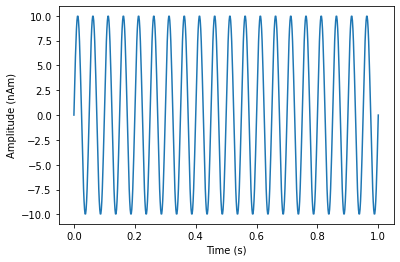

In [47]:
# Vertex to simulate activity at
sim_vertex=420
# Frequency of simulated sinusoid (Hz)
freq=20
# Strength of simulated activity (nAm)
dipole_moment=10
# Size of simulated patch of activity (mm)
sim_patch_size=5
# SNR of simulated data (dB)
SNR=-5

# Generate 1s of a sine wave at a sampling rate of 600Hz (to match the data file)
time=np.linspace(0,1,601)
sim_signal=np.sin(time*freq*2*np.pi).reshape(1,-1)
plt.plot(time,dipole_moment*sim_signal[0,:])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (nAm)')

In [56]:
# Simulate at a vertex on the pial surface
pial_vertex=sim_vertex
white_vertex=(n_layers-1)*verts_per_surf+sim_vertex

prefix=f'sim_{sim_vertex}_pial.'

with matlab_context() as eng:
    # Generate simulated data
    pial_sim_fname=run_current_density_simulation(base_fname, prefix, pial_vertex, sim_signal, dipole_moment, 
                                                  sim_patch_size, SNR, mat_eng=eng)    

    # Coregister data to multilayer mesh
    coregister(nas, lpa, rpa, mri_fname, multilayer_mesh_fname, pial_sim_fname, mat_eng=eng)

    # Run inversion on simulated data in a 5Hz window around the simulated frequency using the multilayer surface
    [_,_,MU]=invert_ebb(multilayer_mesh_fname, pial_sim_fname, n_layers, foi=[freq-2.5, freq+2.5],
                        patch_size=patch_size, n_temp_modes=n_temp_modes, gain_mat_fname=gainmat, 
                        return_mu_matrix=True, mat_eng=eng)
    
    # Get pial and white source time series
    pial_layer_ts=load_source_time_series(pial_sim_fname, mu_matrix=MU, vertices=[pial_vertex], mat_eng=eng)
    white_layer_ts=load_source_time_series(pial_sim_fname, mu_matrix=MU, vertices=[white_vertex], mat_eng=eng)
    
# Compute power
pial_var=np.squeeze(np.var(pial_layer_ts,axis=1))
white_var=np.squeeze(np.var(white_layer_ts,axis=1))

# Compare power t statistic should be positive (more power in pial layer)
t_statistic, p_value = ttest_rel(pial_var, white_var)
print(f't({pial_var.shape[-1]-1})={t_statistic}, p={p_value}')

t(61)=179.38281438491555, p=9.010234360570278e-85


In [57]:
# Simulate at the corresponding vertex on the white matter surface
prefix=f'sim_{sim_vertex}_white.'

with matlab_context() as eng:
    # Generate simulated data
    white_sim_fname=run_current_density_simulation(base_fname, prefix, white_vertex, sim_signal, dipole_moment, 
                                                   sim_patch_size, SNR, mat_eng=eng)    

    # Coregister data to multilayer mesh
    coregister(nas, lpa, rpa, mri_fname, multilayer_mesh_fname, white_sim_fname, mat_eng=eng)

    # Run inversion on simulated data in a 5Hz window around the simulated frequency using the multilayer surface
    [_,_,MU]=invert_ebb(multilayer_mesh_fname, white_sim_fname, n_layers, foi=[freq-2.5, freq+2.5],
                        patch_size=patch_size, n_temp_modes=n_temp_modes, gain_mat_fname=gainmat, 
                        return_mu_matrix=True, mat_eng=eng)
    
    # Get pial and white source time series
    pial_layer_ts=load_source_time_series(pial_sim_fname, mu_matrix=MU, vertices=[pial_vertex], mat_eng=eng)
    white_layer_ts=load_source_time_series(pial_sim_fname, mu_matrix=MU, vertices=[white_vertex], mat_eng=eng)

# Compute power
pial_var=np.squeeze(np.var(pial_layer_ts,axis=1))
white_var=np.squeeze(np.var(white_layer_ts,axis=1))

# Compare power t statistic should be negative (more power in white matter layer)
t_statistic, p_value = ttest_rel(pial_var, white_var)
print(f't({pial_var.shape[-1]-1})={t_statistic}, p={p_value}')

Smoothing ./test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
t(61)=-221.810863963255, p=2.182486266458421e-90


In [60]:
# Now simulate at the corresponding vertex on each layer, and for each simulation, compute power in
# all layers
all_layerPow=[]

with matlab_context() as eng:
    for l in range(n_layers):
        print(f'Simulating in layer {l}')
        l_vertex=l*verts_per_surf+sim_vertex
        prefix=f'sim_{sim_vertex}_{l}.'
        
        l_sim_fname=run_current_density_simulation(base_fname, prefix, l_vertex, sim_signal, dipole_moment, 
                                                   sim_patch_size, SNR, viz=False, mat_eng=eng) 

        coregister(nas, lpa, rpa, mri_fname, multilayer_mesh_fname, l_sim_fname, viz=False, mat_eng=eng)
        
        [_,_,MU]=invert_ebb(multilayer_mesh_fname, l_sim_fname, n_layers, foi=[freq-2.5, freq+2.5], 
                            patch_size=patch_size, n_temp_modes=n_temp_modes, gain_mat_fname=gainmat, 
                            return_mu_matrix=True, viz=False, mat_eng=eng)

        roi_pow=[]
        for l in range(n_layers):
            layer_roi_vert=l*verts_per_surf+sim_vertex
            layer_ts=load_source_time_series(l_sim_fname, mu_matrix=MU, vertices=[layer_roi_vert], mat_eng=eng)
            roi_pow.append(np.squeeze(np.var(layer_ts,axis=1)))

        all_layerPow.append(roi_pow)
all_layerPow=np.array(all_layerPow)

Simulating in layer 0
Smoothing ./test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Simulating in layer 1
Smoothing ./test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Simulating in layer 2
Smoothing ./test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Simulating in layer 3
Smoothing ./test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Simulating in layer 4
Smoothing ./test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Simulating in layer 5
Smoothing ./test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Simulating in layer 6
Smoothing ./test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Simulating in layer 7
Smoothing ./test_output/su

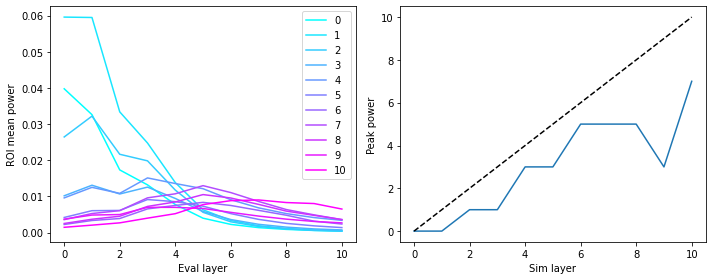

In [65]:
# Average power over trials
mean_layerPow=np.mean(all_layerPow,axis=-1)

col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(10,4))

# For each simulation, plot the power in each layer model
plt.subplot(1,2,1)
for l in range(n_layers):
    layerPow=mean_layerPow[l,:]
    plt.plot(layerPow, label=f'{l}', color=col_r[l,:])
plt.legend()
plt.xlabel('Eval layer')
plt.ylabel('ROI mean power')

# For each simulation, find which layer had the greatest power
plt.subplot(1,2,2)
peaks=[]
for l in range(n_layers):
    layerPow=mean_layerPow[l,:]
    pk=np.argmax(layerPow)
    peaks.append(pk)
plt.plot(peaks)
plt.xlim([-0.5,10.5])
plt.ylim([-0.5,10.5])
plt.plot([0,10],[0,10],'k--')
plt.xlabel('Sim layer')
plt.ylabel('Peak power')
plt.tight_layout()

In [66]:
# Delete simulation files

# Iterate over all items in the directory
for item in os.listdir(tmp_dir):
    item_path = os.path.join(tmp_dir, item)

    # Check if it's a file or a directory
    if os.path.isfile(item_path):
        # Delete the file
        os.remove(item_path)
    elif os.path.isdir(item_path):
        # Recursively delete the directory
        shutil.rmtree(item_path)